In [1]:
import pandas as pd
import numpy as np
import torch
import networkx as nx
import pickle
from utils.miscellaneous import read_config
import matplotlib.pyplot as plt

In [2]:
def load_raw_dataset(wdn_name, data_folder):
	'''
	Load tra/val/data for a water distribution network datasets
	-------
	wdn_name : string
		prefix of pickle files to open
	data_folder : string
		path to datasets
	'''

	data_tra = pickle.load(open(f'{data_folder}/train/{wdn_name}.p', "rb"))
	data_val = pickle.load(open(f'{data_folder}/valid/{wdn_name}.p', "rb"))
	data_tst = pickle.load(open(f'{data_folder}/test/{wdn_name}.p', "rb"))

	return data_tra, data_val, data_tst

In [3]:
def plot_r2_time(mlp_results,unrolling_results,gnn_results):
	# Add a new column 'Source' to identify the dataframes
	mlp_results['Source'] = 'MLP'
	unrolling_results['Source'] = 'Unrolling'
	gnn_results['Source'] = 'GNN'

	# Create the scatter plot
	plt.figure(figsize=(10, 6))

	# Scatter plot for MLP results
	plt.scatter(mlp_results['test_time'], mlp_results['r2_test'], s=mlp_results['total_params'] / 1000, c='blue', alpha=0.6, label='MLP')

	# Scatter plot for Unrolling results
	plt.scatter(unrolling_results['test_time'], unrolling_results['r2_test'], s=unrolling_results['total_params'] / 1000, c='green', alpha=0.6, label='Unrolling')

	# Scatter plot for GNN results
	plt.scatter(gnn_results['test_time'], gnn_results['r2_test'], s=gnn_results['total_params'] / 1000, c='red', alpha=0.6, label='GNN')

	plt.xlabel('Test Time')
	plt.ylabel('$R^2$')
	plt.title('$R^2$ Test vs. Test Time')
	plt.legend()
	plt.grid(True)
	plt.savefig(f'./experiments/visualizations/r2_test_vs_test_time_{wdn}.png')

Working with FOS
Working with PES
Working with BAK
Working with BLA


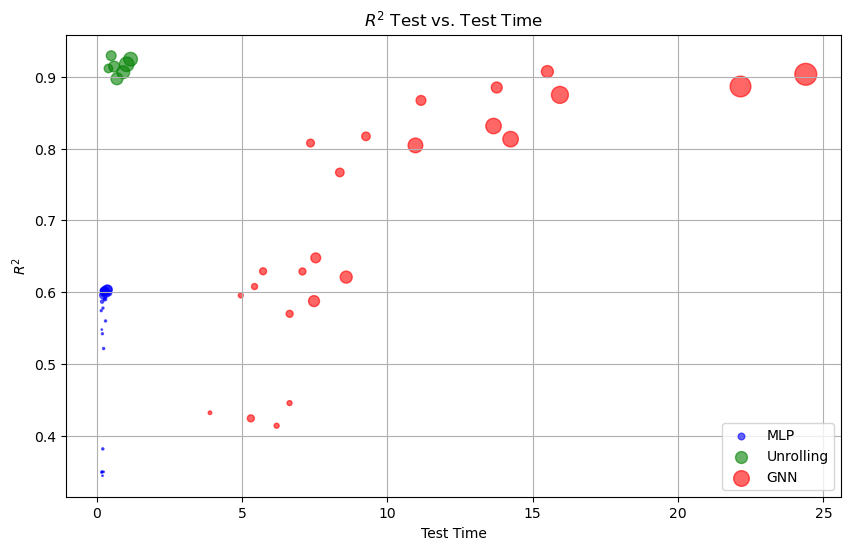

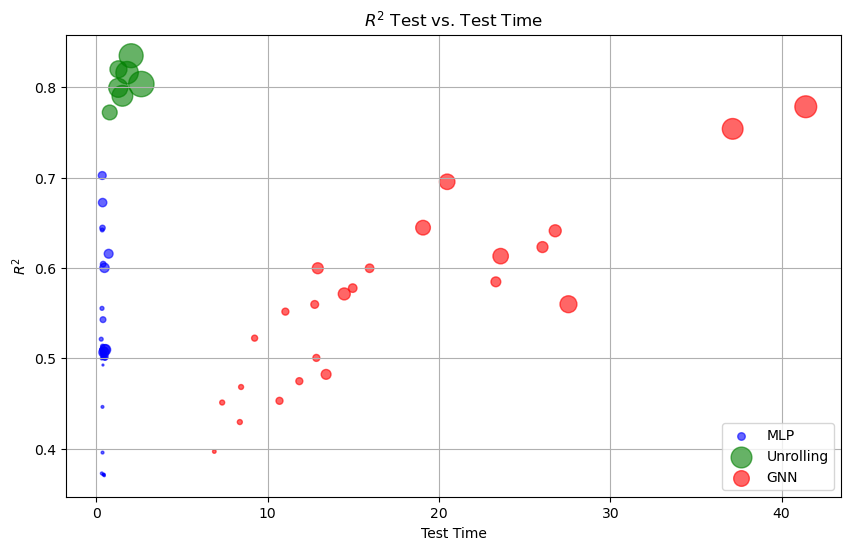

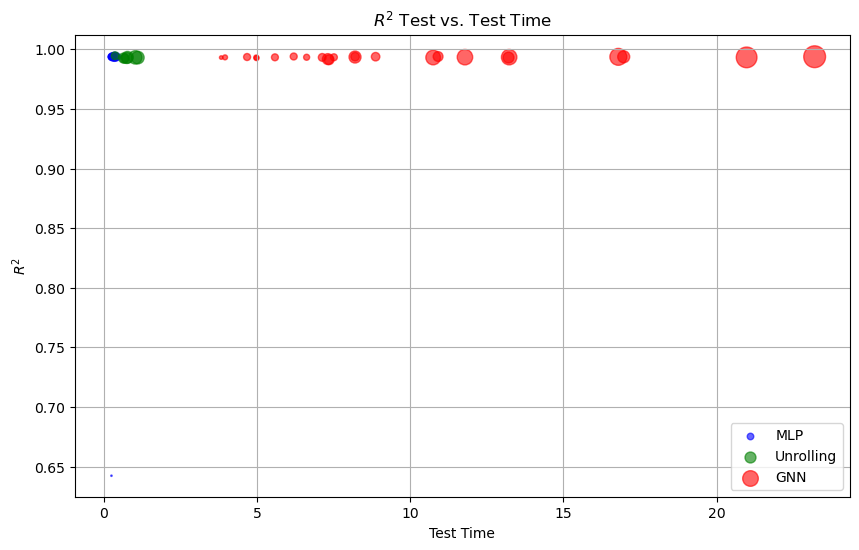

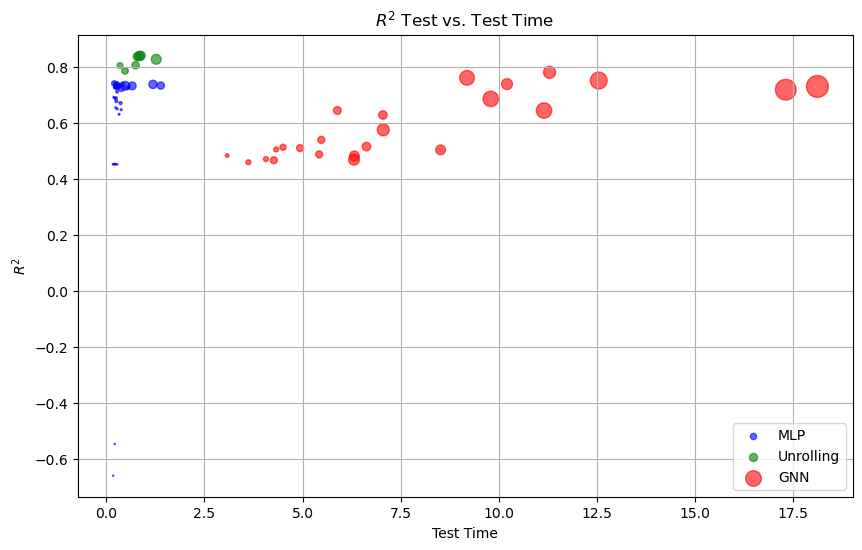

In [4]:
cfg = read_config("config_unrolling_GNN.yaml")
data_folder = cfg['data_folder']
all_wdn_names = cfg['networks']

for wdn in all_wdn_names:
	print(f'Working with {wdn}')
	mlp_results = pd.read_csv(f'./experiments/Results MLP and Unrolling 8000/{wdn}/MLP/results_MLP.csv').drop(columns=['Unnamed: 0'])
	unrolling_results =  pd.read_csv(f'./experiments/Results MLP and Unrolling 8000/{wdn}/UnrollingModel/results_UnrollingModel.csv').drop(columns=['Unnamed: 0'])
	gnn_results =  pd.read_csv(f'./experiments/unrolling_GNN_WDN/{wdn}/GNN_ChebConv/results_GNN_ChebConv.csv').drop(columns=['Unnamed: 0'])
	plot_r2_time(mlp_results,unrolling_results,gnn_results)

In [3]:
def plot_errors(real,mlp_preds,unrolling_preds,gnn_preds, wdn):

	error_mlp = abs(real - mlp_preds)
	error_unrolling = abs(real - unrolling_preds)
	error_gnn = abs(real - gnn_preds)

	errors = pd.concat([error_mlp, error_unrolling, error_gnn], axis=1, keys=['MLP', 'Unrolling', 'GNN'])

	# Plot the errors for each column using a bar plot
	plt.figure(figsize=(12, 6))
	errors.plot(kind='bar')
	plt.xlabel('Node')
	plt.ylabel('Mean Absolute Error (m)')
	plt.title('Mean Absolut Error for Each Node')
	plt.xticks(rotation=45, ha='right')
	plt.grid(axis='y', linestyle='--', alpha=0.7)
	plt.tight_layout()
	plt.savefig(f'./experiments/visualizations/mean_squared_error_{wdn}.png')
	plt.show()

In [6]:
import torch.nn as nn
from torch.nn import *
class MLP(nn.Module):
	def __init__(self, num_outputs, hid_channels, indices, num_layers=6):
		super(MLP, self).__init__()
		torch.manual_seed(42)
		self.hid_channels = hid_channels
		self.indices = indices
		self.num_flows = indices[2] - indices[1]

		layers = [Linear(indices[4], hid_channels),
				  nn.ReLU()]

		for l in range(num_layers-1):
			layers += [Linear(hid_channels, hid_channels),
					   nn.ReLU()]

		layers += [Linear(hid_channels, num_outputs)]

		self.main = nn.Sequential(*layers)

	def forward(self, x):

		x = self.main(x)

		return x

In [7]:
class UnrollingModel(nn.Module):
	def __init__(self, num_outputs, indices, num_blocks):
		super(UnrollingModel, self).__init__()
		torch.manual_seed(42)
		self.indices = indices
		self.num_heads = indices[0]
		self.num_flows = indices[2]-indices[1]
		self.num_blocks = num_blocks

		self.hidQ0_H = Linear(indices[2]-indices[1], self.num_heads)
		self.hidH0_Q = Linear(indices[1]-indices[0], self.num_flows)
		self.hidH0_H = Linear(indices[1]-indices[0], self.num_heads)
		self.hidq_Q =  Linear(indices[0], self.num_flows)
		self.hid_S = Sequential(Linear(indices[4] - indices[2], self.num_flows),
						   nn.ReLU())

		self.hid_HF = nn.ModuleList()
		self.hid_FH = nn.ModuleList()
		self.resQ = nn.ModuleList()
		self.hidD_Q = nn.ModuleList()
		self.hidD_H = nn.ModuleList()

		for i in range(num_blocks):
			self.hid_HF.append(Sequential(Linear(self.num_heads,self.num_flows), nn.ReLU()))
			self.hid_FH.append(Sequential(Linear(self.num_flows, self.num_heads),
						   nn.ReLU()))
			self.resQ.append(Sequential(Linear(self.num_flows,self.num_heads),
						   nn.ReLU()))
			self.hidD_Q.append(Sequential(Linear(self.num_flows,self.num_flows),
						   nn.ReLU()))
			self.hidD_H.append(Linear(self.num_flows,self.num_heads))

		self.out = Linear(self.num_flows, num_outputs)

	def forward(self, x):

		q, H0, Q, hid_S = x[:,:self.indices[0]], x[:,self.indices[0]:self.indices[1]], x[:,self.indices[1]:self.indices[2]], x[:,self.indices[2]:]
		res_H0_Q, res_q_Q, res_Q_H, res_H0_H, res_S_Q = self.hidH0_Q(H0), self.hidq_Q(q), self.hidQ0_H(Q), self.hidH0_H(H0), self.hid_S(hid_S)


		for i in range(self.num_blocks-1):

			D_Q = self.hidD_Q[i](torch.mul(Q, res_S_Q))
			D_H = self.hidD_H[i](D_Q)
			hid_x = torch.mul(D_Q,torch.sum(torch.stack([Q, res_q_Q, res_H0_Q]),dim=0))
			H = self.hid_FH[i](hid_x)
			hid_x = self.hid_HF[i](torch.mul(torch.sum(torch.stack([H,res_H0_H,res_Q_H]),dim=0), D_H))
			Q = torch.sub(Q,hid_x)
			res_Q_H = self.resQ[i](Q)
			if torch.any(H > 100).item():
				break

		return self.out(Q)

In [4]:
import torch_geometric
from torch_geometric.utils import to_networkx

# constant indexes for node and edge features
HEAD_INDEX = 0
BASEDEMAND_INDEX = 1
TYPE_INDEX = 2
DIAMETER_INDEX = 0
LENGTH_INDEX = 1
ROUGHNESS_INDEX = 2
FLOW_INDEX = 3

def create_dataset(database, normalizer=None, HW_rough_minmax=[60, 150],add_virtual_reservoirs=False, output='pressure'):
	'''
	Creates working datasets dataset from the pickle databases
	------
	database : list
		each element in the list is a pickle file containing Data objects
	normalization: dict
		normalize the dataset using mean and std
	'''
	# Roughness info (Hazen-Williams) / TODO: remove the hard_coding
	minR = HW_rough_minmax[0]
	maxR = HW_rough_minmax[1]

	graphs = []

	for i in database:
		graph = torch_geometric.data.Data()

		# Node attributes
		# elevation_head = i.elevation + i.base_head
		# elevation_head = i.elevation.clone()
		# elevation_head[elevation_head == 0] = elevation_head.mean()

		min_elevation = min(i.elevation[i.type_1H == 0])
		head = i.pressure + i.base_head + i.elevation
		# elevation_head[i.type_1H == 1] = head[i.type_1H == 1]
		# elevation = elevation_head - min_elevation

		# base_demand = i.base_demand * 1000  # convert to l/s
		# graph.x = torch.stack((i.elevation, i.base_demand, i.type_1H*i.base_head), dim=1).float()
		graph.x = torch.stack((i.elevation+i.base_head, i.base_demand, i.type_1H), dim=1).float()
		# graph.x = torch.stack((i.elevation+i.base_head, i.base_demand, i.type_1H), dim=1).float()

		# Position and ID
		graph.pos = i.pos
		graph.ID = i.ID

		# Edge index (Adjacency matrix)
		graph.edge_index = i.edge_index

		# Edge attributes
		diameter = i.diameter
		length = i.length
		roughness = i.roughness
		graph.edge_attr = torch.stack((diameter, length, roughness), dim=1).float()

		# pressure = i.pressure
		# graph.y = pressure.reshape(-1,1)

		# Graph output (head)
		if output == 'head':
			graph.y  = head[i.type_1H == 0].reshape(-1, 1)
		else:
			graph.y = i.pressure[i.type_1H == 0].reshape(-1, 1)
			# pressure[i.type_1H == 1] = 0 # THIS HAS TO BE DONE BETTER
			# graph.y = pressure


		# normalization
		if normalizer is not None:
			graph = normalizer.transform(graph)

		graphs.append(graph)
	A12 = nx.incidence_matrix(to_networkx(graphs[0]), oriented=True).toarray().transpose()
	return graphs, A12

def create_dataset_MLP_from_graphs(graphs, features=['nodal_demands', 'base_heads','diameter','roughness','length'],no_res_out=True):

	# index edges to avoid duplicates: this considers all graphs to be UNDIRECTED!
	ix_edge = graphs[0].edge_index.numpy().T
	ix_edge = (ix_edge[:, 0] < ix_edge[:, 1])

	# position of reservoirs
	ix_res = graphs[0].x[:,TYPE_INDEX].numpy()>0
	indices = []
	for ix_feat, feature in enumerate(features):
		for ix_item, item in enumerate(graphs):
			if feature == 'diameter':
				x_ = item.edge_attr[ix_edge,DIAMETER_INDEX]
			elif feature == 'roughness':
				# remove reservoirs
				x_ = item.edge_attr[ix_edge,ROUGHNESS_INDEX]
			elif feature == 'length':
				# remove reservoirs
				x_ = item.edge_attr[ix_edge,LENGTH_INDEX]
			elif feature == 'nodal_demands':
				# remove reservoirs
				x_ = item.x[~ix_res,BASEDEMAND_INDEX]
			elif feature == 'base_heads':
				x_ = item.x[ix_res,HEAD_INDEX]
			else:
				raise ValueError(f'Feature {feature} not supported.')
			if ix_item == 0:
				x = x_
			else:
				x = torch.cat((x, x_), dim=0)
		if ix_feat == 0:
			X = x.reshape(len(graphs), -1)
		else:
			X = torch.cat((X, x.reshape(len(graphs), -1)), dim=1)
		indices.append(X.shape[1])
	for ix_item, item in enumerate(graphs):
		# remove reservoirs from y as well
		if ix_item == 0:
			if no_res_out == True:
				y = item.y
			else:
				y = item.y[~ix_res]
		else:
			if no_res_out == True:
				y = torch.cat((y, item.y), dim=0)
			else:
				y = torch.cat((y, item.y[~ix_res]), dim=0)
	y = y.reshape(len(graphs), -1)

	return torch.utils.data.TensorDataset(X, y), X.shape[1], indices

def create_incidence_matrices(graphs,incidence_matrix):

	# position of reservoirs

	ix_res = graphs[0].x[:,TYPE_INDEX].numpy()>0
	ix_edge = graphs[0].edge_index.numpy().T
	ix_edge = (ix_edge[:, 0] < ix_edge[:, 1])
	incidence_matrix = incidence_matrix[ix_edge,:]
	A10 = incidence_matrix[:, ix_res]
	A12 = incidence_matrix[:, ~ix_res]
	A12[np.where(A10 == 1),:] *= -1
	A10[np.where(A10 == 1),:] *= -1
	return A10, A12

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator,TransformerMixin

class PowerLogTransformer(BaseEstimator,TransformerMixin):
	def __init__(self,log_transform=False,power=4,reverse=True):
		if log_transform == True:
			self.log_transform = log_transform
			self.power = None
		else:
			self.power = power
			self.log_transform = None
		self.reverse=reverse
		self.max_ = None
		self.min_ = None

	def fit(self,X,y=None):
		self.max_ = np.max(X)
		self.min_ = np.min(X)
		return self

	def transform(self,X):
		if self.log_transform==True:
			if self.reverse == True:
				return np.log1p(self.max_-X)
			else:
				return np.log1p(X-self.min_)
		else:
			if self.reverse == True:
				return (self.max_-X)**(1/self.power )
			else:
				return (X-self.min_)**(1/self.power )

	def inverse_transform(self,X):
		if self.log_transform==True:
			if self.reverse == True:
				return (self.max_ - np.exp(X))
			else:
				return (np.exp(X) + self.min_)
		else:
			if self.reverse == True:
				return (self.max_ - X**self.power )
			else:
				return (X**self.power + self.min_)


class GraphNormalizer:
	def __init__(self, x_feat_names=['elevation', 'base_demand', 'base_head'],
				 ea_feat_names=['diameter', 'length', 'roughness'], output='pressure'):
		# store
		self.x_feat_names = x_feat_names
		self.ea_feat_names = ea_feat_names
		self.output = output

		# create separate scaler for each feature (can be improved, e.g., you can fit a scaler for multiple columns)
		self.scalers = {}
		for feat in self.x_feat_names:
			if feat == 'elevation':
				self.scalers[feat] = PowerLogTransformer(log_transform=True, reverse=False)
			else:
				self.scalers[feat] = MinMaxScaler()
		self.scalers[output] = PowerLogTransformer(log_transform=True, reverse=True)
		for feat in self.ea_feat_names:
			if feat == 'length':
				self.scalers[feat] = PowerLogTransformer(log_transform=True, reverse=False)
			else:
				self.scalers[feat] = MinMaxScaler()

	def fit(self, graphs):
		''' Fit the scalers on an array of x and ea features
        '''
		x, y, ea = from_graphs_to_pandas(graphs)
		for ix, feat in enumerate(self.x_feat_names):
			self.scalers[feat] = self.scalers[feat].fit(x[:, ix].reshape(-1, 1))
		self.scalers[self.output] = self.scalers[self.output].fit(y.reshape(-1, 1))
		for ix, feat in enumerate(self.ea_feat_names):
			self.scalers[feat] = self.scalers[feat].fit(ea[:, ix].reshape(-1, 1))
		return self

	def transform(self, graph):
		''' Transform graph based on normalizer
        '''
		graph = graph.clone()
		for ix, feat in enumerate(self.x_feat_names):
			temp = graph.x[:, ix].numpy().reshape(-1, 1)
			graph.x[:, ix] = torch.tensor(self.scalers[feat].transform(temp).reshape(-1))
		for ix, feat in enumerate(self.ea_feat_names):
			temp = graph.edge_attr[:, ix].numpy().reshape(-1, 1)
			graph.edge_attr[:, ix] = torch.tensor(self.scalers[feat].transform(temp).reshape(-1))
		graph.y = torch.tensor(self.scalers[self.output].transform(graph.y.numpy().reshape(-1, 1)).reshape(-1))
		return graph

	def inverse_transform(self, graph):
		''' Perform inverse transformation to return original features
        '''
		graph = graph.clone()
		for ix, feat in enumerate(self.x_feat_names):
			temp = graph.x[:, ix].numpy().reshape(-1, 1)
			graph.x[:, ix] = torch.tensor(self.scalers[feat].inverse_transform(temp).reshape(-1))
		for ix, feat in enumerate(self.ea_feat_names):
			temp = graph.edge_attr[:, ix].numpy().reshape(-1, 1)
			graph.edge_attr[:, ix] = torch.tensor(self.scalers[feat].inverse_transform(temp).reshape(-1))
		graph.y = torch.tensor(self.scalers[self.output].inverse_transform(graph.y.numpy().reshape(-1, 1)).reshape(-1))
		return graph

	def transform_array(self, z, feat_name):
		'''
            This is for MLP dataset; it can be done better (the entire thing, from raw data to datasets)
        '''
		return torch.tensor(self.scalers[feat_name].transform(z).reshape(-1))

	def inverse_transform_array(self, z, feat_name):
		'''
            This is for MLP dataset; it can be done better (the entire thing, from raw data to datasets)
        '''
		return self.scalers[feat_name].inverse_transform(z)

def from_graphs_to_pandas(graphs, l_x=3, l_ea=3):
	x = []
	y = []
	ea = []
	for i, graph in enumerate(graphs):
		x.append(graph.x.numpy())
		y.append(graph.y.reshape(-1, 1).numpy())
		ea.append(graph.edge_attr.numpy())
	return np.concatenate(x, axis=0), np.concatenate(y, axis=0), np.concatenate(ea, axis=0)


In [ ]:
data_folder = './data'
wdn_best_configs = {'PES': [28,5,23], 'FOS': [33,1,22], 'BAK': [0,0,6], 'BLA': [28,4,22]}
gn = GraphNormalizer()
wdn = 'PES'
print(f'Working with {wdn}')
tra_database, _,_ = load_raw_dataset(wdn, data_folder)
tra_dataset, A12_bar = create_dataset(tra_database)
gn.fit(tra_dataset)
real = gn.inverse_transform_array(pd.read_csv(f'./experiments/Results MLP and Unrolling 8000/{wdn}/MLP/pred/testing/real.csv').drop(columns=['Unnamed: 0']), 'pressure')
mlp_pred = gn.inverse_transform_array(pd.read_csv(f'./experiments/Results MLP and Unrolling 8000/{wdn}/MLP/pred/testing/{wdn_best_configs[wdn][0]}.csv').drop(columns=['Unnamed: 0']), 'pressure')
unrolling_pred = gn.inverse_transform_array(pd.read_csv(f'./experiments/Results MLP and Unrolling 8000/{wdn}/UnrollingModel/pred/testing/{wdn_best_configs[wdn][1]}.csv').drop(columns=['Unnamed: 0']), 'pressure')
gnn_pred = gn.inverse_transform_array(pd.read_csv(f'./experiments/unrolling_GNN_WDN/{wdn}/GNN_ChebConv/pred/testing/{wdn_best_configs[wdn][2]}.csv').drop(columns=['Unnamed: 0']), 'pressure')

plot_errors(real,mlp_pred,unrolling_pred,gnn_pred, wdn)

Working with PES


C:\Users\Albert\AppData\Local\Temp\ipykernel_15296\1199134345.py:92: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A12 = nx.incidence_matrix(to_networkx(graphs[0]), oriented=True).toarray().transpose()


In [ ]:
import torch

model_name = 'MLP'
wdn = 'FOS'
PATH = f'./experiments/Results Unrolling/{wdn}/{model_name}/models/1.csv'

model = torch.load(PATH)

# remove PES anomaly
if wdn == 'PES':
	if len(tra_database)>4468:
		del tra_database[4468]
		print('Removed PES anomaly')
		print('Check',tra_database[4468].pressure.mean())

# get GRAPH datasets    # later on we should change this and use normal scalers from scikit
tra_dataset, A12_bar = create_dataset(tra_database)
gn = GraphNormalizer()
gn = gn.fit(tra_dataset)
tra_dataset, _ = create_dataset(tra_database,normalizer=gn)
val_dataset,_ = create_dataset(val_database,normalizer=gn)
tst_dataset,_ = create_dataset(tst_database,normalizer=gn)
node_size, edge_size = tra_dataset[0].x.size(-1), tra_dataset[0].edge_attr.size(-1)
# number of nodes
# n_nodes=tra_dataset[0].x.shape[0]
n_nodes=(1-tra_database[0].type_1H).numpy().sum() # remove reservoirs
# dataloader
# transform dataset for MLP
# We begin with the MLP versions, when I want to add GNNs, check Riccardo's code
A10,A12 = create_incidence_matrices(tra_dataset, A12_bar)
tra_dataset_MLP, num_inputs, indices = create_dataset_MLP_from_graphs(tra_dataset)
val_dataset_MLP = create_dataset_MLP_from_graphs(val_dataset)[0]
tst_dataset_MLP = create_dataset_MLP_from_graphs(tst_dataset)[0]
tra_loader = torch.utils.data.DataLoader(tra_dataset_MLP,
										 batch_size=256, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset_MLP,
										 batch_size=256, shuffle=False, pin_memory=True)
tst_loader = torch.utils.data.DataLoader(tst_dataset_MLP,
										 batch_size=256, shuffle=False, pin_memory=True)

In [ ]:
model(tra_dataset_MLP)